In [3]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns


/Users/eliasrubin/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/Users/eliasrubin/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [4]:
# simulated psf function
def makePsf(x, sigma1=1.0, b=0.0, sigma_ratio=2, xc=0):
    I = np.exp(-0.5*((x - xc)/sigma1)**2) + b*np.exp(-0.5*((x - xc)/(sigma_ratio*sigma1))**2)
    I /= np.sum(I)*(x[1] - x[0])
    
    return I

def manyPsf(bList, samples=30):
    X = []
    for b in bList:
        x0 = np.zeros(2*samples + 1)
        x0[0:samples] = np.linspace(-1, 1, samples)
        x0[samples:2*samples] = makePsf(np.linspace(-1,1,samples), b=b)
        x0[-1] = b
        X.append(x0)
    return X

In [5]:
from sklearn.cross_validation import train_test_split
X = manyPsf(np.linspace(0, 10, 5000))
X = np.vstack(X)
X_train, X_test = train_test_split(X, test_size=0.1, random_state=42)

This is the trickier part.  We want to train each layer in sequence, and use the weights we get from each layer
to initialize a stacked deep autoencoder.  We can train each layer by using the output hidden representation from the previous autoencoder as input to the next one.  Training the deep autoencoder will use backpropogation to refine the weights in both the encoder and decoder.  Our data each have 61 features, so we will use a 61 - 30 - 15 - 7 - 3 encoder, which means we want to obtain a code of just 3 real numbers.

One thing that I am not sure about is the nonlinearity Hinton uses.  Should I be using a sigmoid/tanh activation function for everything after the first layer when training the encoders?  In that case, I probably should use the same activation function in the stacked encoder/decoder.

I know the code is a little repetitive but I wanted to be explicit about what was going on.

In [16]:
from keras.layers import containers, AutoEncoder, Dense
from keras import models

encoder1 = containers.Sequential()
encoder1.add(Dense(output_dim=30, input_dim=61, init='glorot_normal'))
decoder1 = containers.Sequential()
decoder1.add(Dense(output_dim=61, input_dim=30, init='glorot_normal'))
ae1 = AutoEncoder(encoder=encoder1, decoder=decoder1, output_reconstruction=True)

encoder2 = containers.Sequential()
encoder2.add(Dense(output_dim=15, input_dim=30, init='glorot_normal', activation='sigmoid'))
decoder2 = containers.Sequential()
decoder2.add(Dense(output_dim=30, input_dim=15, init='glorot_normal'))
ae2 = AutoEncoder(encoder=encoder2, decoder=decoder2, output_reconstruction=True)

encoder3 = containers.Sequential()
encoder3.add(Dense(output_dim=7, input_dim=15, init='glorot_normal', activation='sigmoid'))
decoder3 = containers.Sequential()
decoder3.add(Dense(output_dim=15, input_dim=7, init='glorot_normal'))
ae3 = AutoEncoder(encoder=encoder3, decoder=decoder3, output_reconstruction=True)

encoder4 = containers.Sequential()
encoder4.add(Dense(output_dim=3, input_dim=7, init='glorot_normal', activation='sigmoid'))
decoder4 = containers.Sequential()
decoder4.add(Dense(output_dim=7, input_dim=3, init='glorot_normal'))
ae4 = AutoEncoder(encoder=encoder4, decoder=decoder4, output_reconstruction=True)

model1 = models.Sequential()
model1.add(ae1)
model2 = models.Sequential()
model2.add(ae2)
model3 = models.Sequential()
model3.add(ae3)
model4 = models.Sequential()
model4.add(ae4)

Now we train each of the autoencoders in sequence.  To get the hidden prediction, we have to disable output reconstruction and then predict X_train.

In [17]:
model1.compile(optimizer='sgd', loss='mse')
model1.fit(X_train, X_train, nb_epoch = 100)
ae1.output_reconstruction = False
model1.compile(optimizer='sgd', loss='mse')
h1 = model1.predict(X_train)

Epoch 1/100
4500/4500 [==============================] - 0s - loss: 1.0560     
Epoch 2/100
4500/4500 [==============================] - 0s - loss: 0.4436     
Epoch 3/100
4500/4500 [==============================] - 0s - loss: 0.2478     
Epoch 4/100
4500/4500 [==============================] - 0s - loss: 0.1420     
Epoch 5/100
4500/4500 [==============================] - 0s - loss: 0.0892     
Epoch 6/100
4500/4500 [==============================] - 0s - loss: 0.0643     
Epoch 7/100
4500/4500 [==============================] - 0s - loss: 0.0516     
Epoch 8/100
4500/4500 [==============================] - 0s - loss: 0.0440     
Epoch 9/100
4500/4500 [==============================] - 0s - loss: 0.0388     
Epoch 10/100
4500/4500 [==============================] - 0s - loss: 0.0348     
Epoch 11/100
4500/4500 [==============================] - 0s - loss: 0.0315     
Epoch 12/100
4500/4500 [==============================] - 0s - loss: 0.0288     
Epoch 13/100
4500/4500 [=============

In [18]:
model2.compile(optimizer='sgd', loss='mse')
model2.fit(h1, h1, nb_epoch = 100)
ae2.output_reconstruction = False
model2.compile(optimizer='sgd', loss='mse')
h2 = model2.predict(h1)

Epoch 1/100
4500/4500 [==============================] - 0s - loss: 1.2953     
Epoch 2/100
4500/4500 [==============================] - 0s - loss: 1.0708     
Epoch 3/100
4500/4500 [==============================] - 0s - loss: 0.8919     
Epoch 4/100
4500/4500 [==============================] - 0s - loss: 0.7433     
Epoch 5/100
4500/4500 [==============================] - 0s - loss: 0.6208     
Epoch 6/100
4500/4500 [==============================] - 0s - loss: 0.5240     
Epoch 7/100
4500/4500 [==============================] - 0s - loss: 0.4484     
Epoch 8/100
4500/4500 [==============================] - 0s - loss: 0.3897     
Epoch 9/100
4500/4500 [==============================] - 0s - loss: 0.3447     
Epoch 10/100
4500/4500 [==============================] - 0s - loss: 0.3100     
Epoch 11/100
4500/4500 [==============================] - 0s - loss: 0.2834     
Epoch 12/100
4500/4500 [==============================] - 0s - loss: 0.2630     
Epoch 13/100
4500/4500 [=============

In [19]:
model3.compile(optimizer='sgd', loss='mse')
model3.fit(h2, h2, nb_epoch = 100)
ae3.output_reconstruction = False
model3.compile(optimizer='sgd', loss='mse')
h3 = model3.predict(h2)

Epoch 1/100
4500/4500 [==============================] - 0s - loss: 0.6072     
Epoch 2/100
4500/4500 [==============================] - 0s - loss: 0.4580     
Epoch 3/100
4500/4500 [==============================] - 0s - loss: 0.3525     
Epoch 4/100
4500/4500 [==============================] - 0s - loss: 0.2757     
Epoch 5/100
4500/4500 [==============================] - 0s - loss: 0.2186     
Epoch 6/100
4500/4500 [==============================] - 0s - loss: 0.1754     
Epoch 7/100
4500/4500 [==============================] - 0s - loss: 0.1422     
Epoch 8/100
4500/4500 [==============================] - 0s - loss: 0.1167     
Epoch 9/100
4500/4500 [==============================] - 0s - loss: 0.0968     
Epoch 10/100
4500/4500 [==============================] - 0s - loss: 0.0812     
Epoch 11/100
4500/4500 [==============================] - 0s - loss: 0.0691     
Epoch 12/100
4500/4500 [==============================] - 0s - loss: 0.0595     
Epoch 13/100
4500/4500 [=============

In [20]:
model4.compile(optimizer='sgd', loss='mse')
model4.fit(h3, h3, nb_epoch = 100)
ae4.output_reconstruction = False
model4.compile(optimizer='sgd', loss='mse')
h4 = model4.predict(h3)

Epoch 1/100
4500/4500 [==============================] - 0s - loss: 0.3720     
Epoch 2/100
4500/4500 [==============================] - 0s - loss: 0.2530     
Epoch 3/100
4500/4500 [==============================] - 0s - loss: 0.1734     
Epoch 4/100
4500/4500 [==============================] - 0s - loss: 0.1194     
Epoch 5/100
4500/4500 [==============================] - 0s - loss: 0.0826     
Epoch 6/100
4500/4500 [==============================] - 0s - loss: 0.0573     
Epoch 7/100
4500/4500 [==============================] - 0s - loss: 0.0399     
Epoch 8/100
4500/4500 [==============================] - 0s - loss: 0.0279     
Epoch 9/100
4500/4500 [==============================] - 0s - loss: 0.0196     
Epoch 10/100
4500/4500 [==============================] - 0s - loss: 0.0139     
Epoch 11/100
4500/4500 [==============================] - 0s - loss: 0.0100     
Epoch 12/100
4500/4500 [==============================] - 0s - loss: 0.0073     
Epoch 13/100
4500/4500 [=============

Now we can use the weights from each network to initialize a stacked autoencoder with 4 layers on each end

In [21]:
W1 = ae1.get_weights()
W2 = ae2.get_weights()
W3 = ae3.get_weights()
W4 = ae4.get_weights()

encoder = containers.Sequential()
encoder.add(Dense(output_dim = 30, input_dim = 61, weights=W1[0:2]))
encoder.add(Dense(output_dim = 15, weights = W2[0:2], activation='sigmoid'))
encoder.add(Dense(output_dim = 7, weights = W3[0:2], activation='sigmoid'))
encoder.add(Dense(output_dim = 3, weights = W4[0:2], activation='sigmoid'))

decoder = containers.Sequential()
decoder.add(Dense(output_dim = 7, input_dim = 3, weights = W4[2:4], activation='linear'))
decoder.add(Dense(output_dim = 15, weights = W3[2:4], activation='linear'))
decoder.add(Dense(output_dim = 30, weights = W2[2:4], activation='linear'))
decoder.add(Dense(output_dim = 61, weights = W1[2:4]))

masterAE = AutoEncoder(encoder=encoder, decoder=decoder, output_reconstruction=True)
masterModel = models.Sequential()
masterModel.add(masterAE)

In [22]:
masterModel.compile(optimizer='sgd', loss='mse')
masterModel.fit(X_train, X_train, nb_epoch=100)

Epoch 1/100
4500/4500 [==============================] - 0s - loss: 0.1363     
Epoch 2/100
4500/4500 [==============================] - 0s - loss: 0.1361     
Epoch 3/100
4500/4500 [==============================] - 0s - loss: 0.1360     
Epoch 4/100
4500/4500 [==============================] - 0s - loss: 0.1360     
Epoch 5/100
4500/4500 [==============================] - 0s - loss: 0.1359     
Epoch 6/100
4500/4500 [==============================] - 0s - loss: 0.1359     
Epoch 7/100
4500/4500 [==============================] - 0s - loss: 0.1359     
Epoch 8/100
4500/4500 [==============================] - 0s - loss: 0.1358     
Epoch 9/100
4500/4500 [==============================] - 0s - loss: 0.1358     
Epoch 10/100
4500/4500 [==============================] - 0s - loss: 0.1357     
Epoch 11/100
4500/4500 [==============================] - 0s - loss: 0.1357     
Epoch 12/100
4500/4500 [==============================] - 0s - loss: 0.1356     
Epoch 13/100
4500/4500 [=============

In [23]:
representations = masterModel.predict(X_test)

Plot all the representations against the test data.  useful to see if large irregularities are present for everything.

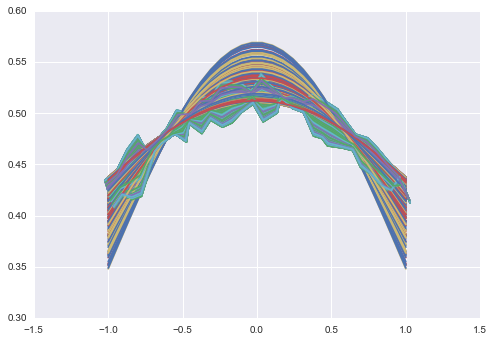

In [24]:
plt.figure()
for i in range(len(X_test)):
    plt.plot(X_test[i][0:30], X_test[i][30:60])
    plt.plot(representations[i][0:30], representations[i][30:60])
plt.show()

Plot a few representative curves.

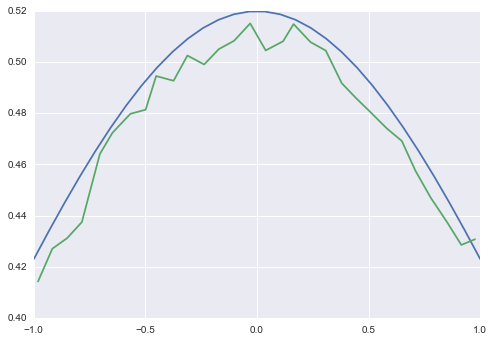

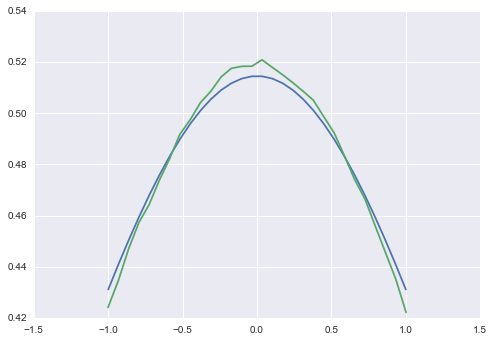

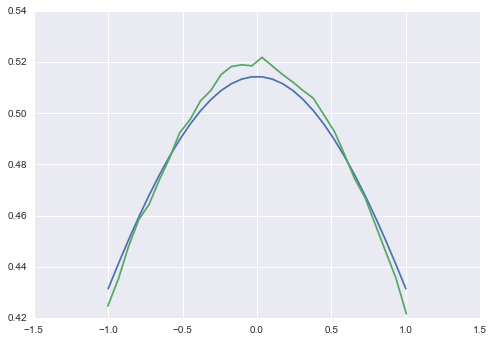

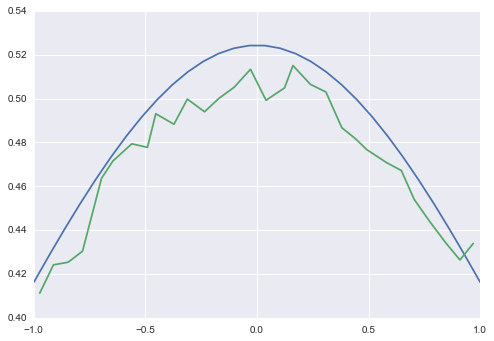

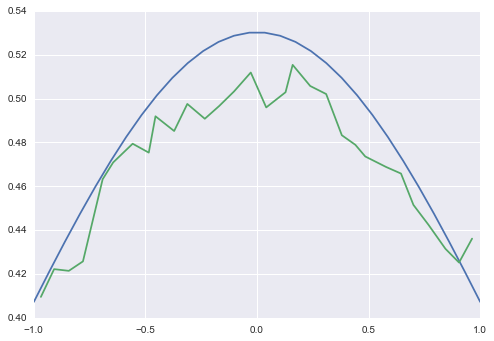

In [25]:
plt.figure()
for i in range(0, 5):
    plt.plot(X_test[i][0:30], X_test[i][30:60])
    plt.plot(representations[i][0:30], representations[i][30:60])
    plt.show()